In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torch.optim as optim

import torchvision.transforms as transforms
import numpy as np 
import matplotlib.pyplot as plt
import os
from glob import glob
from PIL import Image
from tqdm import tqdm

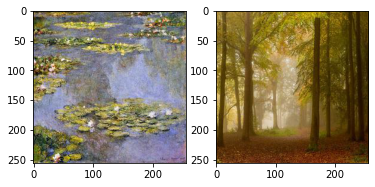

(256, 256, 3)
(256, 256, 3)


In [2]:
monet_files = glob('/kaggle/input/gan-getting-started/monet_jpg/*')
photo_files = glob('/kaggle/input/gan-getting-started/photo_jpg/*')

test_img = Image.open(monet_files[0])
test_photo = Image.open(photo_files[0])
plt.subplot(121)
plt.imshow(test_img)
plt.subplot(122)
plt.imshow(test_photo)
plt.show()

print(np.asarray(test_img).shape)
print(np.asarray(test_photo).shape)

In [3]:
# Hyperparameters
BATCH_SIZE = 8
LR = 2e-4
NUM_EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LAMBDA_CYCLE = 10
LAMBDA_ID = 0

### Create dataset

In [4]:
class Images(Dataset):
    def __init__(self, root_photo, root_painting, transforms):
        self.photo_path = root_photo
        self.painting_path = root_painting
        self.transform = transforms
        self.photos = os.listdir(root_photo)
        self.paintings = os.listdir(root_painting)
        self.l_photo = len(self.photos)
        self.l_painting = len(self.paintings)
    
    def __len__(self):
        return max(len(self.photos), len(self.paintings))
    
    def __getitem__(self, idx):
        photo = Image.open(
            self.photo_path + self.photos[idx % self.l_photo]
        ).convert("RGB")
        painting = Image.open(
            self.painting_path + self.paintings[idx % self.l_painting]
        ).convert("RGB")
        photo = self.transform(photo)
        painting = self.transform(painting)
        
        return photo, painting

In [5]:
w = 256
h = 256
channels = 3

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = Images(
    root_painting = '/kaggle/input/gan-getting-started/monet_jpg/',
    root_photo = '/kaggle/input/gan-getting-started/photo_jpg/',
    transforms = transform
)

dataloader = DataLoader(
    dataset, 
    batch_size = BATCH_SIZE,
    shuffle = True
)

### Create generator model

In [6]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, down = True, use_act = True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode = 'reflect', **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace = True) if use_act else nn.Identity()
        )
    def forward(self, x):
        return self.conv(x)

    
class ResidualBlock(nn.Module):
    
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size = 3, padding = 1),
            ConvBlock(channels, channels, use_act = False, kernel_size = 3, padding = 1)
        )
        
    def forward(self, x):
        return x + self.block(x)

    
class Generator(nn.Module):
    
    def __init__(self, img_channels = 3, num_features = 64, num_residuals = 9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                img_channels, 64, kernel_size = 7, stride = 1, 
                padding = 3, padding_mode = 'reflect'
            ),
            nn.ReLU(inplace = True) 
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features, num_features*2, kernel_size = 3, stride = 2, padding = 1
                ),
                ConvBlock(
                    num_features*2, num_features*4, kernel_size = 3, stride = 2, padding = 1
                ),
            ]
        )
        
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features*4, num_features*2, down = False, kernel_size = 3, stride = 2, 
                    padding = 1, output_padding = 1
                ),
                ConvBlock(
                    num_features*2, num_features, down = False, kernel_size = 3, stride = 2, 
                    padding = 1, output_padding = 1
                ),
            ]   
        )
        self.last = nn.Conv2d(
            num_features, img_channels, kernel_size = 7, stride = 1, 
            padding = 3, padding_mode = 'reflect'
        )
        
    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.residual_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

### Create discriminator model

In [7]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias = True, 
                padding_mode = 'reflect'
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(.2)
        )
        
    def forward(self, x):
        return self.conv(x)

    
class Discriminator(nn.Module):
    def __init__(self, in_channels = 3, features = [64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels, features[0], kernel_size = 4, stride = 2, 
                padding = 1, padding_mode = 'reflect'
            ),
            nn.LeakyReLU(.2)
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                Block(in_channels, feature, stride = 1 if feature == features[-1] else 2)
            )
            in_channels = feature
        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size = 4, stride = 1, 
                padding = 1, padding_mode = 'reflect'
            )
        )
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

## Build instances of the models and train

In [8]:
L1_loss = nn.L1Loss()
mse_loss = nn.MSELoss()
   
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

# Create the 4 networks
disc_photo = Discriminator(in_channels = 3).to(DEVICE)
disc_paint = Discriminator(in_channels = 3).to(DEVICE)
gen_paint = Generator(img_channels = 3, num_residuals = 9).to(DEVICE)
gen_photo = Generator(img_channels = 3, num_residuals = 9).to(DEVICE)

# Prepare Adam optimizers
opt_discriminator = optim.Adam(
    list(disc_paint.parameters()) + list(disc_photo.parameters()),
    lr = LR,
    betas = (.5, .999)
)
opt_generator = optim.Adam(
    list(gen_paint.parameters()) + list(gen_photo.parameters()),
    lr = LR,
    betas = (.5, .999)
)

# Let's go for the training
for epoch in range(NUM_EPOCHS):
    running_disc_loss = 0.
    running_gen_loss = 0.
    
    for photo, painting in tqdm(dataloader, leave = True):
        photo = photo.to(DEVICE)
        painting = painting.to(DEVICE)
        
        # First train discriminator
        fake_photo = gen_photo(painting)
        disc_photo_real = disc_photo(photo)
        disc_photo_fake = disc_photo(fake_photo.detach())
        disc_photo_real_loss = mse_loss(disc_photo_real, torch.ones_like(disc_photo_real))
        disc_photo_fake_loss = mse_loss(disc_photo_fake, torch.zeros_like(disc_photo_fake))
        disc_photo_loss =  disc_photo_real_loss + disc_photo_fake_loss
        
        fake_painting = gen_paint(photo)
        disc_paint_real = disc_paint(painting)
        disc_paint_fake = disc_paint(fake_painting.detach())
        
        disc_paint_real_loss = mse_loss(disc_paint_real, torch.ones_like(disc_paint_real))
        disc_paint_fake_loss = mse_loss(disc_paint_fake, torch.zeros_like(disc_paint_fake))
        disc_paint_loss =  disc_paint_real_loss + disc_paint_fake_loss
        
        # Put it together
        disc_loss = (disc_photo_loss + disc_paint_loss) / 2
        
        running_disc_loss += disc_loss / len(dataloader)
        
        opt_discriminator.zero_grad()
        d_scaler.scale(disc_loss).backward()
        d_scaler.step(opt_discriminator)
        d_scaler.update()
        
        # Train Generator
        with torch.cuda.amp.autocast():
            # Adversarial loss for generators
            disc_photo_fake = disc_photo(fake_photo)
            disc_paint_fake = disc_paint(fake_painting)
            loss_gen_paint = mse_loss(disc_paint_fake, torch.ones_like(disc_paint_fake))
            loss_gen_photo = mse_loss(disc_photo_fake, torch.ones_like(disc_photo_fake))
            # Cycle loss
            cycle_paint = gen_paint(fake_photo)
            cycle_photo = gen_photo(fake_painting)
            cycle_paint_loss = L1_loss(painting, cycle_paint)
            cycle_photo_loss = L1_loss(photo, cycle_photo)

            # Identity loss
            id_paint = gen_paint(painting)
            id_photo = gen_photo(photo)
            id_paint_loss = L1_loss(painting, id_paint)
            id_photo_loss = L1_loss(photo, id_photo)
        
            # All losses together
            gen_loss = (
                loss_gen_paint + loss_gen_photo +
                cycle_paint_loss * LAMBDA_CYCLE + cycle_photo_loss * LAMBDA_CYCLE +
                id_paint_loss * LAMBDA_ID + id_photo_loss * LAMBDA_ID
            )
            
            running_gen_loss += gen_loss / len(dataloader)
            
            opt_generator.zero_grad()
            g_scaler.scale(gen_loss).backward()
            g_scaler.step(opt_generator)
            g_scaler.update()           
            
    print(
        f"Epoch {epoch + 1}. Generator loss by epoch: {running_gen_loss}, \
        Discriminator loss by epoch: {running_disc_loss}"
    )

100%|██████████| 880/880 [42:08<00:00,  2.87s/it]


Epoch 1. Generator loss by epoch: 4.9149088859558105,         Discriminator loss by epoch: 0.39582592248916626


100%|██████████| 880/880 [41:23<00:00,  2.82s/it]


Epoch 2. Generator loss by epoch: 4.034764289855957,         Discriminator loss by epoch: 0.3440491259098053


100%|██████████| 880/880 [41:25<00:00,  2.82s/it]


Epoch 3. Generator loss by epoch: 3.92440128326416,         Discriminator loss by epoch: 0.2406182736158371


100%|██████████| 880/880 [41:25<00:00,  2.82s/it]


Epoch 4. Generator loss by epoch: 3.813979148864746,         Discriminator loss by epoch: 0.191701740026474


100%|██████████| 880/880 [41:25<00:00,  2.82s/it]

Epoch 5. Generator loss by epoch: 3.7380666732788086,         Discriminator loss by epoch: 0.15822391211986542


In [11]:
# Save the trained weights
torch.save(disc_photo.state_dict(), '/kaggle/working/disc_photo.pth')
torch.save(disc_paint.state_dict(), '/kaggle/working/disc_paint.pth')
torch.save(gen_photo.state_dict(), '/kaggle/working/gen_photo.pth')
torch.save(gen_paint.state_dict(), '/kaggle/working/gen_paint.pth')

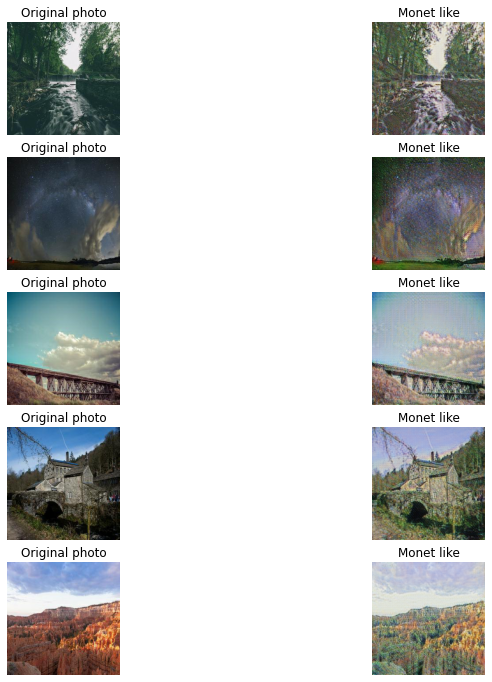

In [10]:
batch = next(iter(dataloader))[0]

_, ax = plt.subplots(5, 2, figsize = (12, 12))

for i in range(5):
    original_img = batch[i]
    predicted_img = None
    with torch.no_grad():
        predicted_img = gen_paint(original_img.unsqueeze(0).to(DEVICE))
    
    ax[i, 0].imshow(original_img.permute(1, 2, 0) * 0.5 + 0.5)
    ax[i, 1].imshow(predicted_img.squeeze(0).permute(1, 2, 0).cpu() * 0.5 + 0.5)
    
    ax[i, 0].set_title("Original photo")
    ax[i, 1].set_title("Monet like")
    
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()